# Exploring San Francisco Restaurant Score Data

For detailed information about the dataset, please visit [their official website](https://data.sfgov.org/Health-and-Social-Services/Restaurant-Scores-LIVES-Standard/pyih-qa8i).

### Downloading the data file

First we send a HTTP GET request and fetch the data

In [1]:
import requests

download_file = requests.get('https://data.sfgov.org/api/views/rkru-6vcg/rows.csv?accessType=DOWNLOAD')
if download_file.status_code != 200:
    print('Error while fetching the data')
else:
    print('Data successfully received')

Data successfully received


Let's look at the location where this data will be saved.

In [2]:
import os
import sys

filename = os.path.join(os.path.dirname(sys.argv[0]), download_file.headers['content-disposition'].split(';')[-1].strip().split('=')[-1])
print('Data will be saved in: ' + filename)

Data will be saved in: c:\users\sudip.a.banerjee\pycharmprojects\learning\venv\lib\site-packages\Air_Traffic_Passenger_Statistics.csv


Now we save the data in a CSV file

In [3]:
op_file = open(filename, 'wb')
op_file.write(download_file.content)
op_file.close()

Let's see the top 5 rows of the file

In [4]:
file = open(filename, 'r')
for _ in range(5):
    print(file.readline())
file.close()

Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131

200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415

200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156



### Reading the file in Pandas

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [6]:
df = pd.read_csv(filename)

In [7]:
df.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090


In [8]:
df['Activity Period'] = pd.to_datetime(df['Activity Period'], format='%Y%m')

In [9]:
print(df['Activity Period'].min())
print(df['Activity Period'].max())

2005-07-01 00:00:00
2020-03-01 00:00:00


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22120 entries, 0 to 22119
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Activity Period              22120 non-null  datetime64[ns]
 1   Operating Airline            22120 non-null  object        
 2   Operating Airline IATA Code  22057 non-null  object        
 3   Published Airline            22120 non-null  object        
 4   Published Airline IATA Code  22057 non-null  object        
 5   GEO Summary                  22120 non-null  object        
 6   GEO Region                   22120 non-null  object        
 7   Activity Type Code           22120 non-null  object        
 8   Price Category Code          22120 non-null  object        
 9   Terminal                     22120 non-null  object        
 10  Boarding Area                22120 non-null  object        
 11  Passenger Count              22120 non-nu

In [11]:
df['Operating Airline'].replace({'United Airlines - Pre 07/01/2013': 'United Airlines'}, inplace=True)
df['Published Airline'].replace({'United Airlines - Pre 07/01/2013': 'United Airlines'}, inplace=True)

Operating Airline vs Time

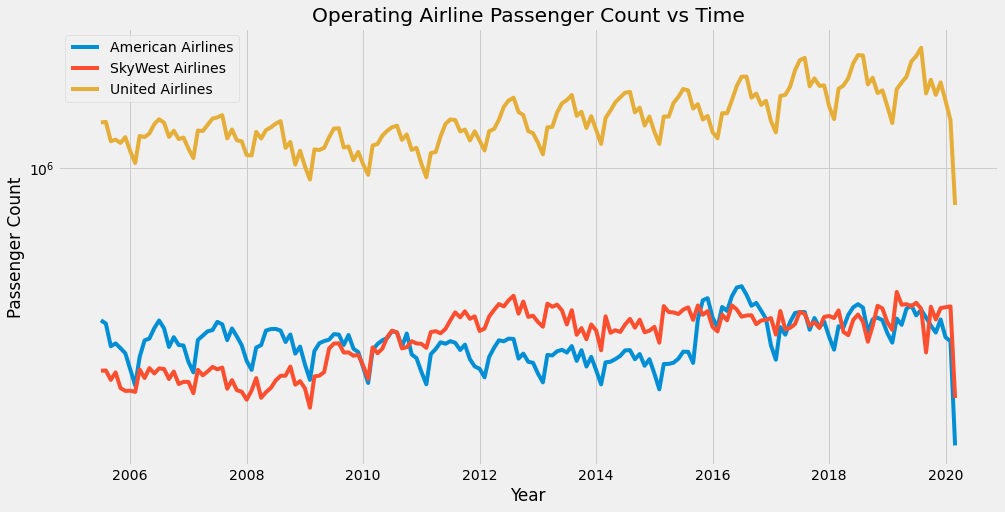

In [12]:
%matplotlib inline
popular_airlines = df[['Operating Airline', 'Passenger Count']]\
                        .sort_values(by='Operating Airline')\
                        .groupby('Operating Airline')\
                        .sum()\
                        .sort_values(by='Passenger Count', ascending=False)\
                        .head(3)\
                        .index\
                        .to_list()
op = df.loc[df['Operating Airline'].isin(popular_airlines), ['Activity Period', 'Operating Airline', 'Passenger Count']]\
        .sort_values(by=['Activity Period', 'Operating Airline'])\
        .groupby(['Activity Period', 'Operating Airline'])\
        .sum()\
        .reset_index()\
        .pivot(index='Activity Period', columns='Operating Airline', values='Passenger Count')\
        .fillna(0)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7.5]
lines = plt.plot(op.index, op)
plt.yscale('log')
plt.legend(lines, op.columns.to_list(), loc='upper left')
plt.title('Operating Airline Passenger Count vs Time')
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.show()

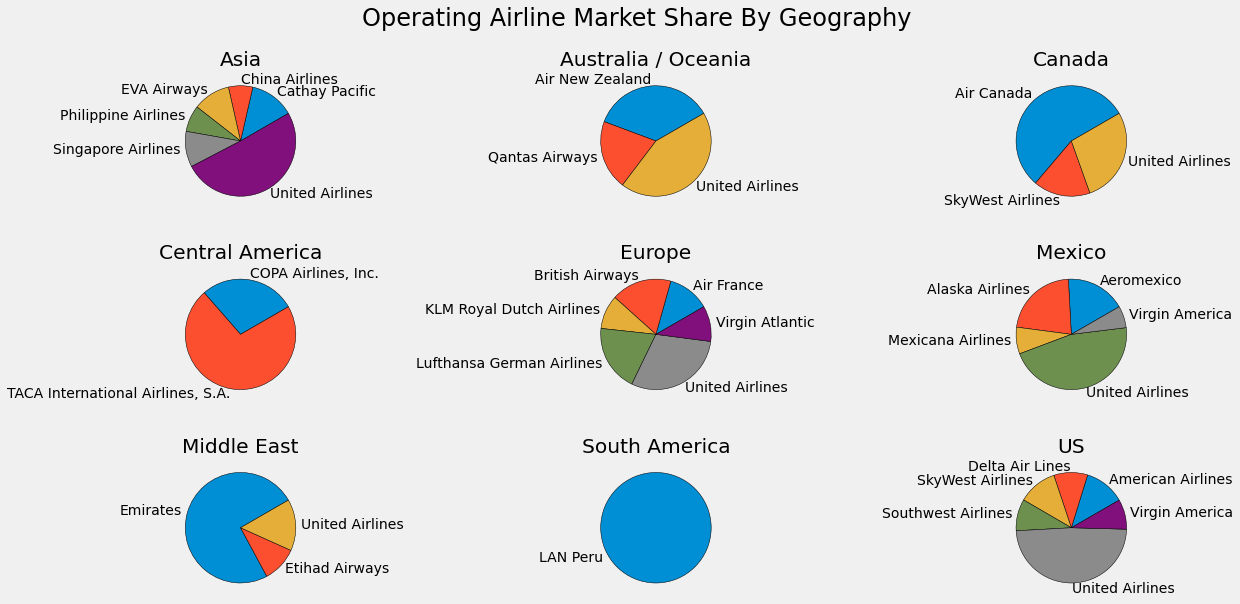

In [13]:
%matplotlib inline
op = df[['GEO Region', 'Operating Airline', 'Passenger Count']]\
        .sort_values(by=['GEO Region', 'Operating Airline'])\
        .groupby(['GEO Region', 'Operating Airline'])\
        .sum()\
        .reset_index()\
        .pivot(index='GEO Region', columns='Operating Airline', values='Passenger Count')\
        .fillna(0)

plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(3, 3, figsize=(18, 9))
for row_num, (idx, row) in enumerate(op.iterrows()):
    ax = axes[row_num // 3, row_num % 3]
    row = row[row.gt(row.sum() * .05)]
    ax.pie(row, labels=row.index, startangle=30, wedgeprops={'edgecolor': 'black'})
    ax.set_title(idx)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Operating Airline Market Share By Geography', fontsize=24)
plt.show()

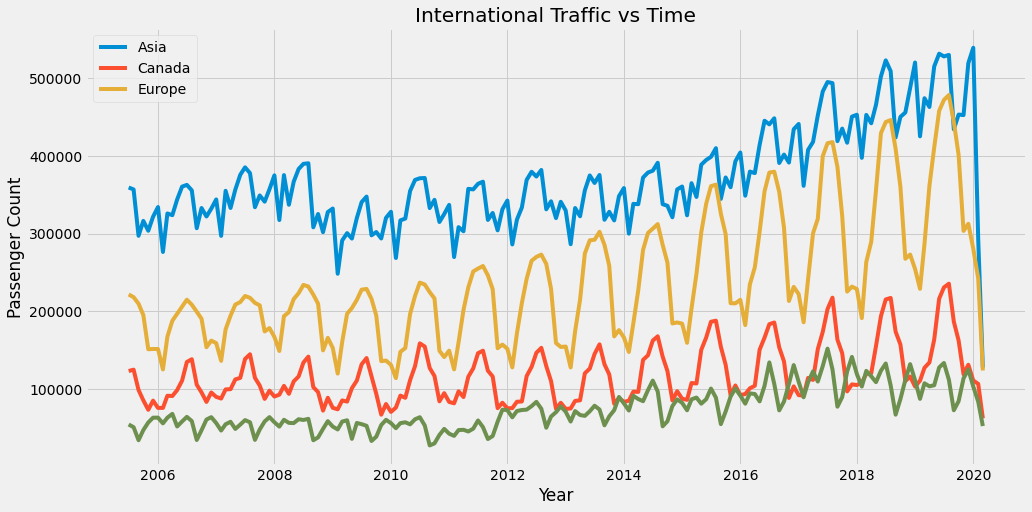

In [14]:
%matplotlib inline
op = df.loc[df['GEO Summary'] == 'International', ['Activity Period', 'GEO Region', 'Passenger Count']]\
        .sort_values(by=['Activity Period', 'GEO Region'])\
        .groupby(['Activity Period', 'GEO Region'])\
        .sum()\
        .reset_index()
op['Rank'] = op.groupby('Activity Period')['Passenger Count'].rank(method='dense', ascending=False)
top_regions = op.loc[op['Rank'] <= 3, 'GEO Region'].unique()
op = op.loc[op['GEO Region'].isin(top_regions), 'Activity Period':'Passenger Count']\
        .reset_index(drop=True)\
        .pivot(index='Activity Period', columns='GEO Region', values='Passenger Count')\
        .fillna(0)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.legend(lines, op.columns.to_list(), loc='upper left')
plt.title('International Traffic vs Time')
plt.xlabel('Year')
plt.ylabel('Passenger Count')
lines = plt.plot(op.index, op)
plt.show()

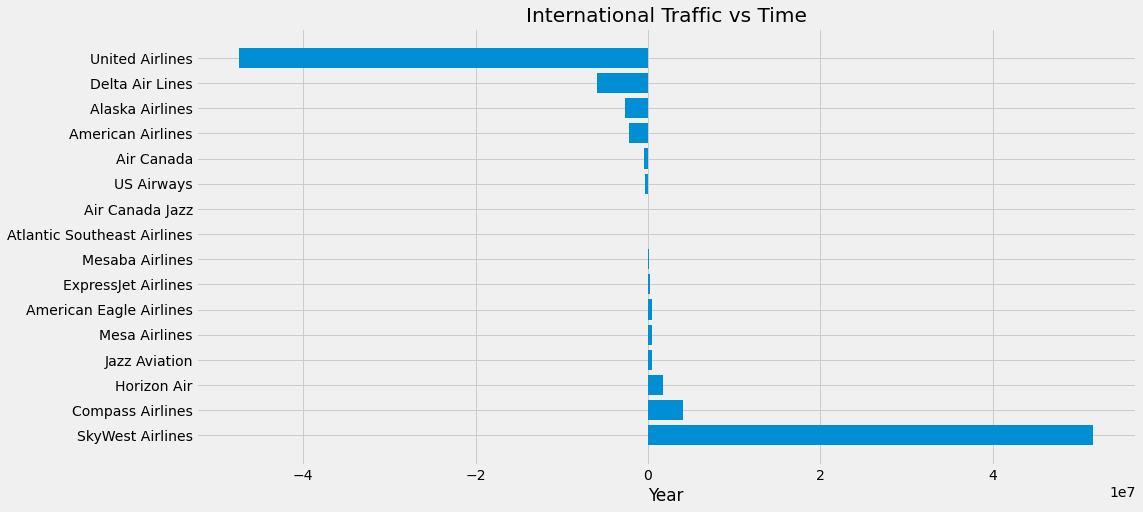

In [15]:
operatied_df = df[['Operating Airline', 'Passenger Count']]\
                    .sort_values(by='Operating Airline')\
                    .groupby('Operating Airline')\
                    .sum()\
                    .reset_index()\
                    .rename(columns={'Operating Airline': 'Airline', 'Passenger Count': 'Operated Passenger Count'})
published_df = df[['Published Airline', 'Passenger Count']]\
                    .sort_values(by='Published Airline')\
                    .groupby('Published Airline')\
                    .sum()\
                    .reset_index()\
                    .rename(columns={'Published Airline': 'Airline', 'Passenger Count': 'Published Passenger Count'})
op = operatied_df.merge(published_df, how='outer', on='Airline').set_index('Airline').fillna(0)
op['Difference'] = op['Operated Passenger Count'].subtract(op['Published Passenger Count'])
op = op.loc[op['Difference'] != 0].sort_values(by='Difference', ascending=False)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.title('International Traffic vs Time')
plt.xlabel('Year')
plt.barh(op.index, op['Difference'])
plt.show()

In [32]:
op = df.loc[df['GEO Summary'] == 'International', ['Activity Period', 'Operating Airline', 'Passenger Count']]
op['Year'] = op['Activity Period'].dt.year
op = op[['Year', 'Operating Airline', 'Passenger Count']].sort_values(by=['Year', 'Operating Airline']).groupby(['Year', 'Operating Airline']).sum().reset_index()

op['Yearly Market Share (%)'] = 0
op['Yearly Growth (%)'] = 0

start_year = int(op['Year'].min())
end_year = int(op['Year'].max())
for ind_year in range(start_year, end_year + 1):
    year_filt = (op['Year'] == ind_year)
    tmp = op.loc[year_filt, 'Passenger Count'].sum()
    op.loc[year_filt, 'Yearly Market Share (%)'] = op.loc[year_filt, 'Passenger Count'].apply(lambda x: (x/tmp)*100)
    if ind_year != start_year:
        airlines = op.loc[year_filt, 'Operating Airline'].to_list()
        for ind_airline in airlines:
            last_year_filt = (op['Year'] == (ind_year - 1))
            airline_filt = (op['Operating Airline'] == ind_airline)
            tmp = op.loc[last_year_filt & airline_filt, 'Passenger Count'].to_list()
            if tmp:
                op.loc[year_filt & airline_filt, 'Yearly Growth (%)'] = op.loc[year_filt & airline_filt, 'Passenger Count'].apply(lambda x: ((x-tmp[0])/tmp[0])*100)

op = op.pivot(index='Operating Airline', columns='Year', values=['Passenger Count', 'Yearly Market Share (%)', 'Yearly Growth (%)']).fillna(0)
op.loc[:, ('Passenger Count', slice(None))]

Passenger Count                   \
Year                                                2005    2006     2007   
Operating Airline                                                           
ABC Aerolineas S.A. de C.V. dba Interjet             0.0     0.0      0.0   
ATA Airlines                                       568.0     0.0    423.0   
Aer Lingus                                           0.0     0.0  14709.0   
Aeromexico                                           0.0     0.0    524.0   
Air Berlin                                           0.0     0.0      0.0   
...                                                  ...     ...      ...   
Volaris Airlines                                     0.0     0.0      0.0   
WOW Air                                              0.0     0.0      0.0   
WestJet Airlines                                 20989.0  1029.0      0.0   
World Airways                                        0.0     0.0      0.0   
XL Airways France                                    0.0     0.0      0.0   

                                                                               \
Year                                          2008     2009     2010     2011   
Operating Airline                                                               
ABC Aerolineas S.A. de C.V. dba Interjet       0.0      0.0      0.0      0.0   
ATA Airlines                                   0.0      0.0      0.0      0.0   
Aer Lingus                                104897.0  65033.0      0.0      0.0   
Aeromexico                                     0.0  60533.0  77648.0  80171.0   
Air Berlin                                     0.0      0.0  24119.0  29205.0   
...                                            ...      ...      ...      ...   
Volaris Airlines                               0.0      0.0      0.0      0.0   
WOW Air                                        0.0      0.0      0.0      0.0   
WestJet Airlines                               0.0  15412.0  77062.0  86150.0   
World Airways                                  0.0    514.0      0.0      0.0   
XL Airways France                              0.0      0.0      0.0      0.0   

                                                                       \
Year                                         2012      2013      2014   
Operating Airline                                                       
ABC Aerolineas S.A. de C.V. dba Interjet      0.0       0.0       0.0   
ATA Airlines                                  0.0       0.0       0.0   
Aer Lingus                                    0.0       0.0   86838.0   
Aeromexico                                74552.0  118783.0  243923.0   
Air Berlin                                30223.0       0.0       0.0   
...                                           ...       ...       ...   
Volaris Airlines                              0.0       0.0       0.0   
WOW Air                                       0.0       0.0       0.0   
WestJet Airlines                          90008.0   85851.0   87970.0   
World Airways                                 0.0       0.0       0.0   
XL Airways France                         15581.0   14907.0   17529.0   

                                                                        \
Year                                          2015      2016      2017   
Operating Airline                                                        
ABC Aerolineas S.A. de C.V. dba Interjet       0.0       0.0       0.0   
ATA Airlines                                   0.0       0.0       0.0   
Aer Lingus                                134582.0  142382.0  153383.0   
Aeromexico                                263919.0  277196.0  326365.0   
Air Berlin                                     0.0   52484.0   99124.0   
...                                            ...       ...       ...   
Volaris Airlines                               0.0   58207.0  104340.0   
WOW Air                                        0.0   82969.0  15

In [36]:
chosen_few_airlines = ['Air India Limited', 'British Airways', 'Cathay Pacific', 'China Airlines', 'Emirates', 'Japan Airlines', 'KLM Royal Dutch Airlines',\
                           'Korean Air Lines', 'Lufthansa German Airlines', 'Qantas Airways', 'Singapore Airlines', 'United Airlines']

In [37]:
op.loc[chosen_few_airlines, ('Yearly Market Share (%)', slice(None))]

Yearly Market Share (%)                        \
Year                                         2005       2006       2007   
Operating Airline                                                         
Air India Limited                        0.000000   0.000000   0.000000   
British Airways                          5.288053   5.047387   4.734147   
Cathay Pacific                           2.857261   2.927750   3.234528   
China Airlines                           3.045639   2.961254   2.769757   
Emirates                                 0.000000   0.000000   0.000000   
Japan Airlines                           2.301498   2.280542   2.253623   
KLM Royal Dutch Airlines                 2.506565   2.178505   2.718450   
Korean Air Lines                         1.468493   1.453738   1.184579   
Lufthansa German Airlines                5.413702   5.287109   4.785917   
Qantas Airways                           0.000000   1.005073   1.553164   
Singapore Airlines                       4.757240   4.590058   4.298590   
United Airlines                         35.386816  35.421485  36.032998   

                                                                       \
Year                            2008       2009       2010       2011   
Operating Airline                                                       
Air India Limited           0.000000   0.000000   0.000000   0.000000   
British Airways             4.588588   4.767832   4.238948   4.640351   
Cathay Pacific              5.119358   5.484934   5.521824   5.275196   
China Airlines              2.573810   2.860955   2.654615   2.459209   
Emirates                    0.032248   1.657208   2.380787   2.389176   
Japan Airlines              1.934174   1.794059   1.696125   1.418854   
KLM Royal Dutch Airlines    2.747272   2.715216   2.396006   2.431724   
Korean Air Lines            1.210149   1.341674   1.419925   1.473858   
Lufthansa German Airlines   4.619164   5.032753   4.578204   5.246253   
Qantas Airways              1.539858   1.460569   1.154077   0.406802   
Singapore Airlines          4.000208   3.723174   3.830116   3.604502   
United Airlines            34.435808  32.280461  32.577058  32.405714   

                                                                       \
Year                            2012       2013       2014       2015   
Operating Airline                                                       
Air India Limited           0.000000   0.000000   0.000000   0.051870   
British Airways             4.389156   4.365162   4.121175   4.201292   
Cathay Pacific              4.768281   4.341631   4.056753   4.001845   
China Airlines              2.377302   2.355226   2.286902   2.045214   
Emirates                    2.370944   2.291332   2.342180   2.655857   
Japan Airlines              1.481543   1.342345   1.120773   1.329312   
KLM Royal Dutch Airlines    2.314226   2.259652   2.175439   2.003875   
Korean Air Lines            1.663431   1.610061   1.514588   1.474479   
Lufthansa German Airlines   5.255782   5.129672   4.914833   4.590377   
Qantas Airways              0.000000   0.000000   0.000000   0.039480   
Singapore Airlines          3.706101   3.870627   3.288178   2.950879   
United Airlines            33.996590  32.890284  32.850341  30.641512   

                                                                       \
Year                            2016       2017       2018       2019   
Operating Airline                                                       
Air India Limited           0.596762   0.976069   1.203146   1.268024   
British Airways             3.693351   3.318793   3.109763   2.856066   
Cathay Pacific              3.926383   3.649517   3.761743   3.463010   
China Airlines              1.892432   1.885015   1.670703   1.479518   
Emirates                    2.420954   2.124357   2.210477   2.076098   
Japan Airlines              1.198788   1.098488   1.063333   1.011249   
KLM Royal Dutch Airlines    2.069789   2.093387   2

In [38]:
op.loc[chosen_few_airlines, ('Yearly Growth (%)', slice(None))].tail(50)

Yearly Growth (%)                                    \
Year                                   2005        2006       2007       2008   
Operating Airline                                                               
Air India Limited                       0.0    0.000000   0.000000   0.000000   
British Airways                         0.0   94.018139  -0.920814  -3.478565   
Cathay Pacific                          0.0  108.283901  16.703592  57.612619   
China Airlines                          0.0   97.637220  -1.196300  -7.461730   
Emirates                                0.0    0.000000   0.000000   0.000000   
Japan Airlines                          0.0  101.418345   4.387967 -14.532540   
KLM Royal Dutch Airlines                0.0   76.665187  31.816602   0.639123   
Korean Air Lines                        0.0  101.226707 -13.923402   1.732867   
Lufthansa German Airlines               0.0   98.515960  -4.378797  -3.886429   
Qantas Airways                          0.0    0.000000  63.240099  -1.269821   
Singapore Airlines                      0.0   96.125751  -1.072942  -7.329177   
United Airlines                         0.0  103.468316   7.458536  -4.830812   

                                                                         \
Year                              2009       2010       2011       2012   
Operating Airline                                                         
Air India Limited             0.000000   0.000000   0.000000   0.000000   
British Airways              -3.842294  -5.378030  11.425208  -0.114464   
Cathay Pacific               -0.848764   7.143543  -2.759605  -4.545654   
China Airlines                2.867158  -1.248113  -5.705914   2.084868   
Emirates                   4655.715757  52.896762   2.145278   4.796217   
Japan Airlines              -14.161267   0.618107 -14.852784  10.267885   
KLM Royal Dutch Airlines     -8.537096  -6.084290   3.303967   0.499521   
Korean Air Lines              2.600765  12.634967   5.652745  19.184979   
Lufthansa German Airlines     0.828752  -3.184601  16.639251   5.793874   
Qantas Airways              -12.222406 -15.905517 -64.121119   0.000000   
Singapore Airlines          -13.866326   9.484703  -4.209145   8.578650   
United Airlines             -13.249564   7.405616   1.251243  10.786337   

                                                                        \
Year                           2013       2014       2015         2016   
Operating Airline                                                        
Air India Limited          0.000000   0.000000   0.000000  1165.414952   
British Airways            1.337978  -0.497938  11.610307    -3.309659   
Cathay Pacific            -7.222244  -1.522475   8.000096     7.913990   
China Airlines             0.948787   2.335512  -2.088478     1.771651   
Emirates                  -1.526452   7.731756  24.144310     0.259868   
Japan Airlines            -7.678517 -12.003639  29.852912    -0.811578   
KLM Royal Dutch Airlines  -0.507883   1.465118   0.847757    13.605880   
Korean Air Lines          -1.374195  -0.856657   6.582661    33.211287   
Lufthansa German Airlines -0.549925   0.978894   2.254415    -1.123959   
Qantas Airways             0.000000   0.000000   0.000000  3704.730795   
Singapore Airlines         6.418428 -10.466507  -1.748650    -1.688147   
United Airlines           -1.420835   5.264930   2.120456     7.952112   

                                                                       
Year                            2017       2018       2019       2020  
Operating Airline                                                      
Air India Limited          77.572867  30.892733  13.122409 -75.830241  
British Airways            -2.443398  -0.499572  -1.421885 -83.090761  
Cathay Pacific              0.911321   9.453982  -1.189244 -86.526308  
China Airlines              8.141299  -5.884259  -4.948151 -81.422590  
Emirates                   -4.733975  10.493451   0.809469 -80.179480

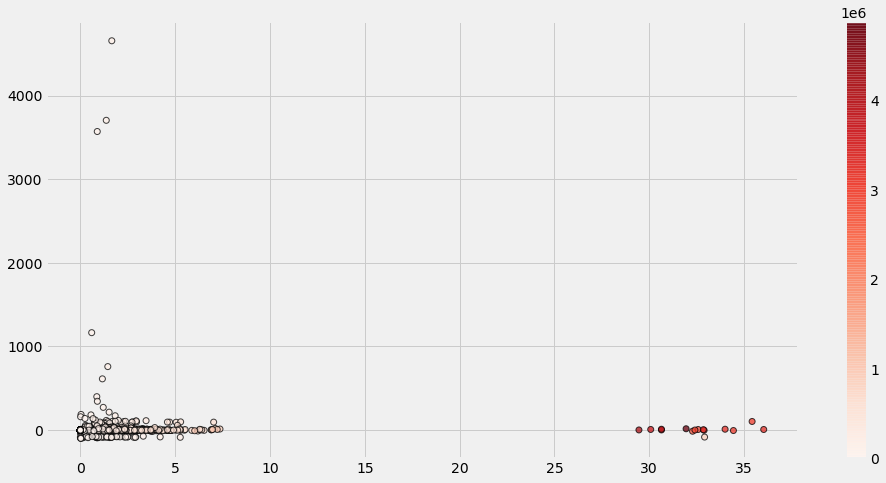

In [84]:
x = []
y = []
c = []
for ind_year in range(start_year + 1, end_year + 1):
    x.append(op.loc[:, ('Yearly Market Share (%)', ind_year)].to_list())
    y.append(op.loc[:, ('Yearly Growth (%)', ind_year)].to_list())
    c.append(op.loc[:, ('Passenger Count', ind_year)].to_list())

plt.scatter(x, y, c=c, edgecolor='black', linewidth=1, alpha=0.75, cmap='Reds')
cbar = plt.colorbar()
plt.show()

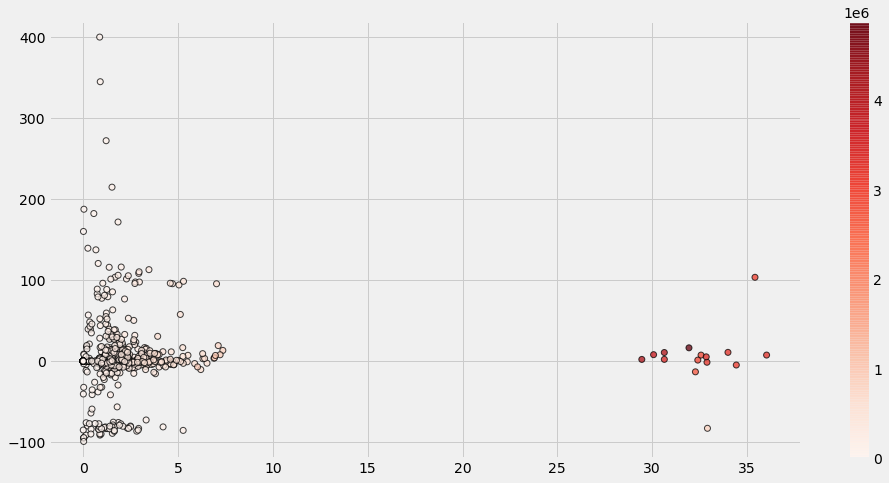

In [101]:
plt.scatter(x, y, c=c, edgecolor='black', linewidth=1, alpha=0.75, cmap='Reds')
cbar = plt.colorbar()
axes = plt.gca()
axes.set_ylim([-120,420])
plt.show()